Import necessary packages

In [82]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.simplefilter(action="ignore")

In [83]:
sales = pd.read_csv("Sarimax Forecasting Total SA.csv", parse_dates=["DATE"], dayfirst=False)\
        .rename(columns={"TOTALSA": "Sales"})
GDP = pd.read_csv("GDP.csv", parse_dates=["DATE"], dayfirst=False)\
        .assign(GDP = lambda cols: cols["GDP"]/1000)

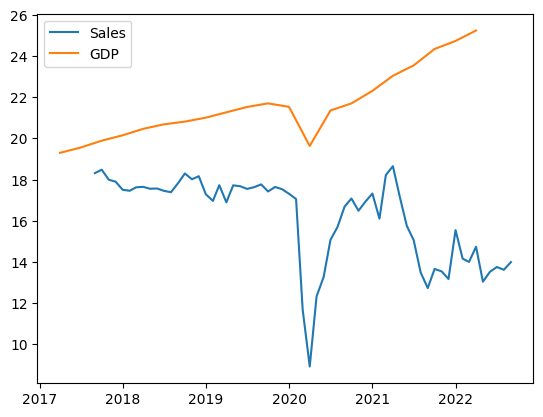

In [84]:
plt.figure()
plt.plot(sales["DATE"], sales["Sales"], label="Sales")
plt.plot(GDP["DATE"], GDP["GDP"], label="GDP")
plt.legend()
plt.show()

In [85]:
GDP = GDP.assign(DATE = lambda cols: cols["DATE"] + pd.Timedelta(32, "D"))\
        .assign(DATE = lambda cols: cols["DATE"].apply(lambda x: x.replace(day=1)))

GDP

,DATE,GDP
0,2017-05-01,19.304506
1,2017-08-01,19.561896
2,2017-11-01,19.894750
3,2018-02-01,20.155486
4,2018-05-01,20.470197
5,2018-08-01,20.687278
6,2018-11-01,20.819269
7,2019-02-01,21.013085
8,2019-05-01,21.272448
9,2019-08-01,21.531839


In [86]:
df =pd.merge(
    left = sales,
    right = GDP,
    on = "DATE",
    how = "outer"
).sort_values("DATE", ascending=True)

df["GDP"] = df["GDP"].interpolate(method="linear", limit_direction="BACKWARD")

GDP_avg_growth_rate = (df["GDP"] / df["GDP"].shift(1)).dropna().tail(5).mean()
for i in range(df.shape[0]):
    if(pd.isnull(df.loc[i, "GDP"])):
        df.loc[i, "GDP"] = df.loc[i-1, "GDP"] * GDP_avg_growth_rate

df = df.dropna(axis=0, how="any").reset_index(drop=True)
df

,DATE,Sales,GDP
0,2017-09-01,18.318,19.672847
1,2017-10-01,18.484,19.783799
2,2017-11-01,17.995,19.894750
3,2017-12-01,17.903,19.981662
4,2018-01-01,17.508,20.068574
...,...,...,...
56,2022-05-01,13.044,25.248476
57,2022-06-01,13.523,25.405137
58,2022-07-01,13.756,25.562771
59,2022-08-01,13.621,25.721382


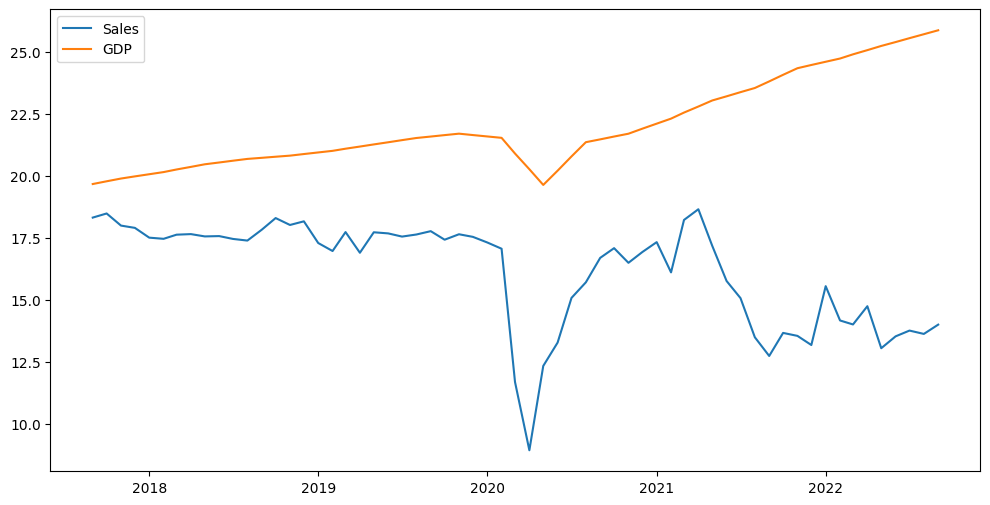

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(df["DATE"], df["Sales"], label="Sales")
plt.plot(df["DATE"], df["GDP"], label="GDP")
plt.legend()
plt.show()

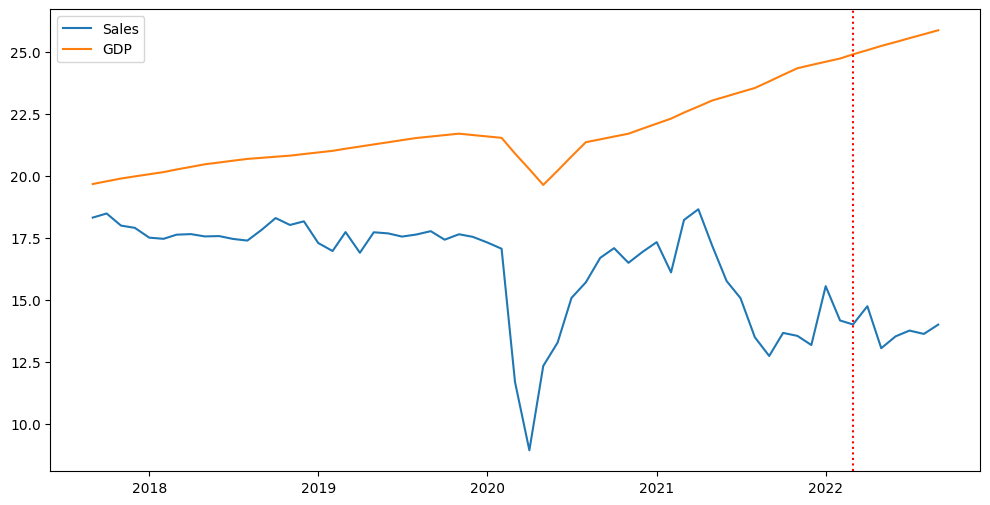

In [88]:
max_training_date = df.tail(7).iloc[0]["DATE"]

plt.figure(figsize=(12, 6))
plt.plot(df["DATE"], df["Sales"], label="Sales")
plt.plot(df["DATE"], df["GDP"], label="GDP")
plt.axvline(max_training_date, color="red", linestyle="dotted")
plt.legend()
plt.show()

Everything behind the vertical dotted line will be used for training our dataset and everything to the right of the line will be used to compare our forecast to the actual data.

In [89]:
df_train = df.loc[df["DATE"] < max_training_date, :]
df_test = df.loc[df["DATE"] >= max_training_date, :]

In [90]:
model = SARIMAX(
        endog = df_train["Sales"],
        exog = df_train["GDP"],
        order = (1,1,3),
        trend = [0,0],
        seasonal_order= (1,0,0, 12)
).fit()

model.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55603D+00    |proj g|=  1.52350D-01

At iterate    5    f=  1.52555D+00    |proj g|=  1.34678D-02

At iterate   10    f=  1.52485D+00    |proj g|=  3.28399D-03

At iterate   15    f=  1.52457D+00    |proj g|=  1.37379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   3.061D-05   1.525D+00
  F =   1.5245704132174041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


KeyboardInterrupt: 

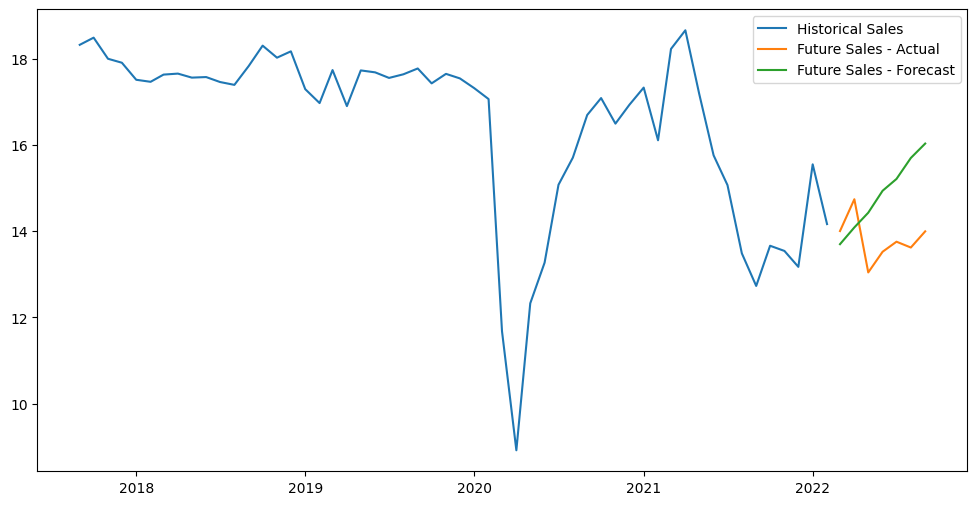

In [ ]:
forecast = model.forecast(steps=df_test.shape[0], exog=df_test["GDP"])

plt.figure(figsize=(12,6))
plt.plot(df_train["DATE"], df_train["Sales"], label="Historical Sales")
plt.plot(df_test["DATE"], df_test["Sales"], label="Future Sales - Actual")
plt.plot(df_test["DATE"], forecast, label="Future Sales - Forecast")
plt.legend()
plt.show()

This prediction is pretty bad since we didn't test yet which order, trend and seasonal_order values are the best. We will do this with a scoring function and parameter search step function.